In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import UnivariateSpline
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.stats import beta
import timeit
from scipy.interpolate import interp1d
import scipy.stats as st
from scipy.special import gamma
from sklearn.preprocessing import MinMaxScaler
import pandas

In [2]:
# the cost function we would like to minimise
def f(x,y):
    return np.mean(3*x**2 + 6*x*y**2 - 2*x**2*y - 7*x*y,axis=0)

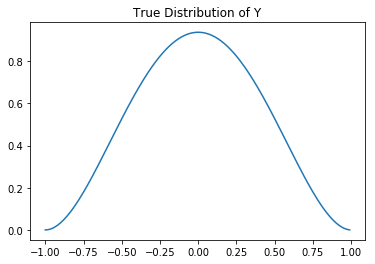

In [3]:
# Define the true distribution
Y = beta(a = 3,b=3,loc=-1,scale=2)

# plot the pdf within the range
x = np.arange (-1, 1, 0.01)
z = Y.pdf(x)
plt.plot(x,z)
plt.title("True Distribution of Y")

In [4]:
# Some experimental hyper parameters

# number of iterations to perform each experiment
n_iter = 10000

# number of samples for each experiment
# we use 50, 100, 150...., 5000 samples
N = [50,200, 800,3200]

In [5]:
x_values = np.linspace(-1,1,1000)

In [6]:
def beta_symmetric_loglikelihood(a, data):
    #scaled = (data - min(data))/(max(data)-min(data))
    
    return -np.sum(np.log(beta.pdf(data, a, a, loc=0.0, scale=1.0)+1e-8))

In [7]:
def beta_loglikelihood(a, data):
    #scaled = (data - min(data))/(max(data)-min(data))
    
    return -np.sum(np.log(beta.pdf(data, a[0], a[1], loc=0.0, scale=1.0)+1e-8))

### Figure 1

Without knowing the support, we fit a symmetric beta distribution i.e. we fix parameters, $a$ = $b$.

/usr/local/lib/python2.7/dist-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


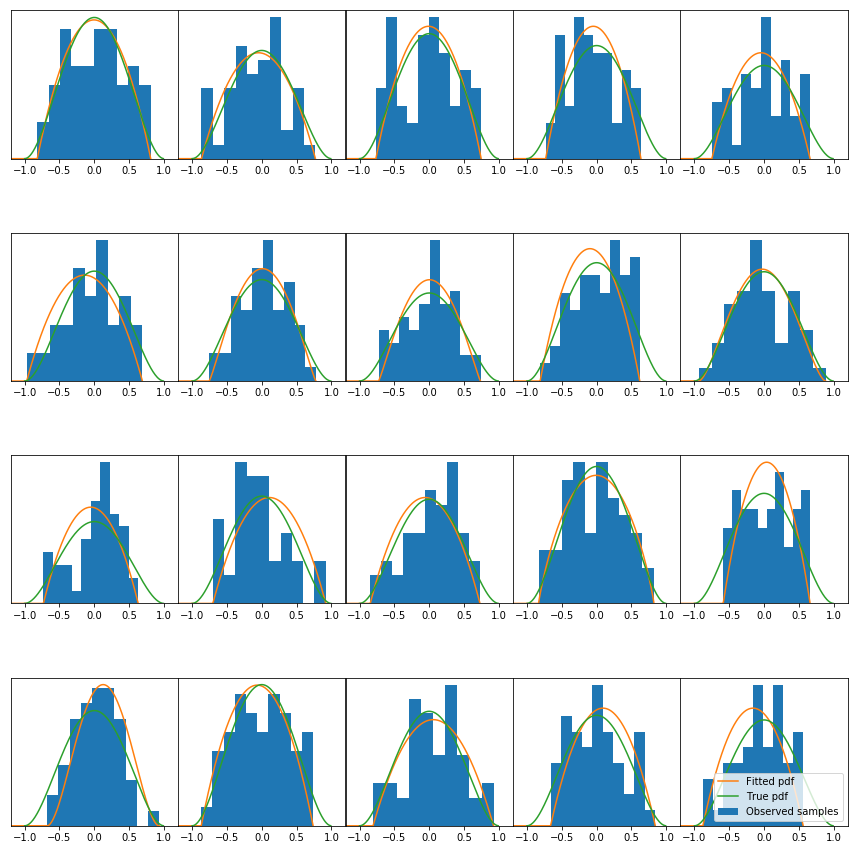

In [8]:
scaler = MinMaxScaler()

fig, axs = plt.subplots(4,5, figsize=(15, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(20):
    S = Y.rvs(50)
    
    scaled = scaler.fit_transform(np.reshape(S,(-1,1)))
    result = minimize(beta_symmetric_loglikelihood,
                  x0=[2.0],
                  args=(scaled),
                    bounds=((0.0,None),))
    fitted_beta = beta(result.x,result.x,loc=scaler.data_min_,scale=scaler.data_range_)
    
    true_xval = scaler.inverse_transform(np.reshape(x_values,(-1,1)))
    y_values = fitted_beta.pdf(true_xval)
    
    #plt.plot(scaler.inverse_transform(x_values),y)
    
    axs[i].hist(S,normed=True,label='Observed samples')
    axs[i].plot(true_xval, y_values,label="Fitted pdf")
    axs[i].plot(x, z,label='True pdf')
    axs[i].yaxis.set_visible(False)
    axs[i].set_xlim([-1.2,1.2])
axs[i].legend()

## Figure 2
Just as a comparison when we don't assume symmetry.

/usr/local/lib/python2.7/dist-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


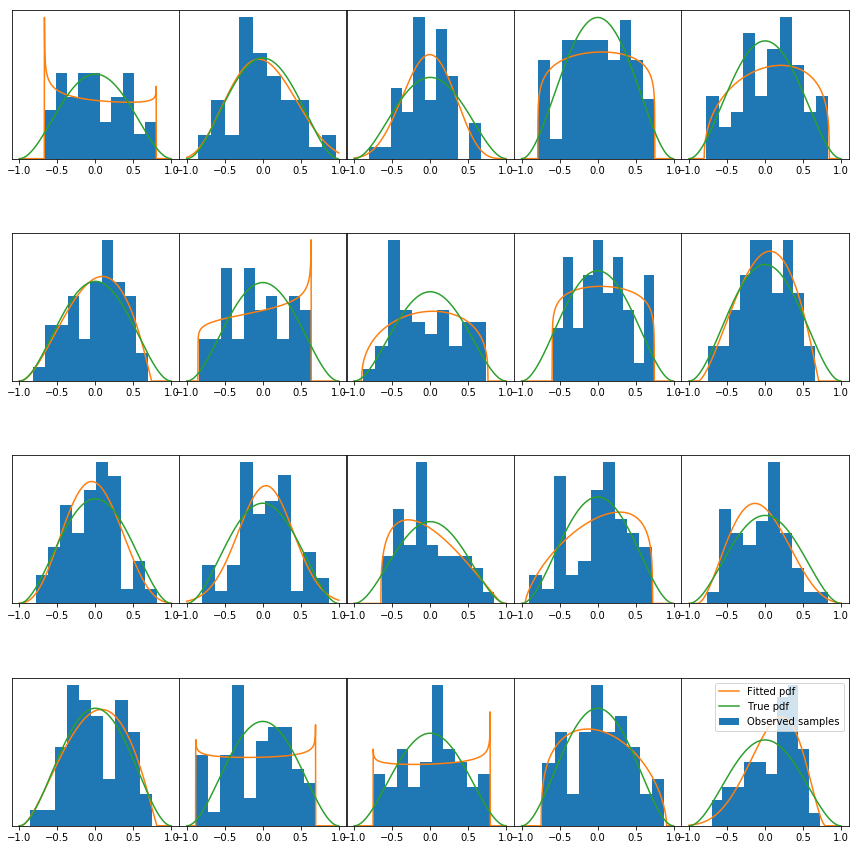

In [9]:
fig, axs = plt.subplots(4,5, figsize=(15, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(20):
    S = Y.rvs(50)

    # fit a beta distribution using MLE
    a1, b1, loc1, scale1 = beta.fit(S)

    fitted_beta = beta(a = a1,b=b1,loc=loc1,scale=scale1)
    
    #plt.hist(S,normed=True)
     # fit the smmetric beta
    
    
    y_values = fitted_beta.pdf(x_values)
    
    axs[i].hist(S,normed=True,label='Observed samples')
    axs[i].plot(x_values, y_values,label="Fitted pdf")
    axs[i].plot(x, z,label='True pdf')
    axs[i].yaxis.set_visible(False)
axs[i].legend()

# minimise cost function

In [10]:
# Some experimental hyper parameters

# number of iterations to perform each experiment
n_iter = 10000

# no of samples to draw from the learned distribution
N_SAMPLES = 20000

# number of samples for each experiment
# we use 50, 100, 150...., 5000 samples
N = [50,200,800,3200]

In [11]:
start_time = timeit.default_timer()

SSA_results = np.zeros((n_iter,len(N)))
for k in range(n_iter):
    for j in range(len(N)):
        # obtain the samples
        S = Y.rvs(N[j])
        # minimise the cost function given the samples, with initial starting point of 0
        res = minimize(f,0.0,args=(S))

        SSA_results[k,j] = res.x
        
elapsed = timeit.default_timer() - start_time
print("This has taken %.2f seconds") %elapsed

This has taken 22.04 seconds


In [12]:
start_time = timeit.default_timer()
MLE_results = np.zeros((n_iter,len(N)))
for k in range(n_iter):
    for j in range(len(N)):
        # obtain the samples
        S = Y.rvs(N[j])
        
        # fit the smmetric beta
        scaled = scaler.fit_transform(np.reshape(S,(-1,1)))
        result = minimize(beta_symmetric_loglikelihood,
                  x0=[2.0],
                  args=(scaled),
                    bounds=((0.0,None),))
        fitted_beta = beta(result.x,result.x,loc=scaler.data_min_,scale=scaler.data_range_)

        
        # now sample from that beta distribution
        MC_samples = fitted_beta.rvs(N_SAMPLES)
        
        # minimise the cost function
        res = minimize(f,0.0,args=(MC_samples))
        
        MLE_results[k,j] = res.x
elapsed = timeit.default_timer() - start_time
print("This has taken %.2f seconds") %elapsed

This has taken 358.58 seconds


In [13]:
start_time = timeit.default_timer()
MLE_old_results = np.zeros((n_iter,len(N)))
for k in range(n_iter):
    for j in range(len(N)):
        # obtain the samples
        S = Y.rvs(N[j])

        # fit the smmetric beta
        scaled = scaler.fit_transform(np.reshape(S,(-1,1)))
        result = minimize(beta_loglikelihood,
                  x0=[2.0,2.0],
                  args=(scaled),
                    bounds=((0.0,None),(0.0,None)))
        fitted_beta = beta(result.x[0],result.x[1],loc=scaler.data_min_,scale=scaler.data_range_)
        
        # now sample from that beta distribution
        MC_samples = fitted_beta.rvs(N_SAMPLES)
        
        # minimise the cost function
        res = minimize(f,0.0,args=(MC_samples))
        
        MLE_old_results[k,j] = res.x
elapsed = timeit.default_timer() - start_time
print("This has taken %.2f seconds") %elapsed

This has taken 464.98 seconds


Plot the deviation of the mean from the true result.

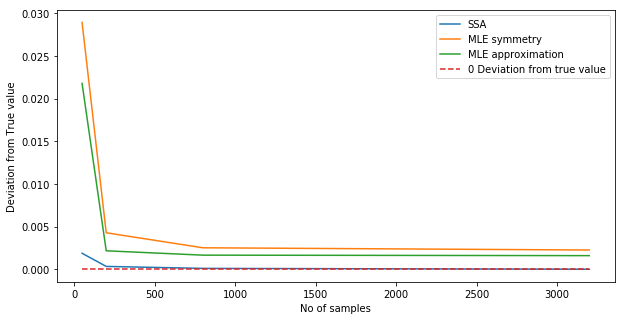

In [14]:
plt.figure(figsize=(10,5))
plt.plot(N,np.abs(np.mean(SSA_results,axis=0)+1.0/7),label='SSA')
plt.plot(N,np.abs(np.mean(MLE_results,axis=0)+1.0/7),label='MLE symmetry')
plt.plot(N,np.abs(np.mean(MLE_old_results,axis=0)+1.0/7),label='MLE approximation')
plt.plot(N,[0]*len(N),'--',label='0 Deviation from true value')
plt.xlabel('No of samples')
plt.ylabel('Deviation from True value')
plt.legend()

Some statistics for the obtained $x^*$ values for $N=50$

In [15]:
df = pandas.DataFrame(SSA_results[:,0],columns=['SSA'])
df['symmetric Beta'] = MLE_results[:,0]
df['full beta'] = MLE_old_results[:,0]
df.describe()

,SSA,symmetric Beta,full beta
count,10000.000000,10000.000000,10000.000000
mean,-0.140963,-0.113930,-0.121074
std,0.061434,0.075587,0.068685
min,-0.375879,-0.380910,-0.371246
25%,-0.182488,-0.166545,-0.167111
50%,-0.140605,-0.114478,-0.123378
75%,-0.099433,-0.062449,-0.079144
max,0.078148,0.136522,0.238130


# Optimise a different function

In [16]:
# the cost function we would like to minimise
def f2(x,y):
    return np.mean(3*(x**2) + 6*x*y**2 - 2*x**2*y - 7*x*y - 5*x,axis=0)

In [17]:
start_time = timeit.default_timer()

SSA_results = np.zeros((n_iter,len(N)))
for k in range(n_iter):
    for j in range(len(N)):
        # obtain the samples
        S = Y.rvs(N[j])
        # minimise the cost function given the samples, with initial starting point of 0
        res = minimize(f2,0.0,args=(S))

        SSA_results[k,j] = res.x
        
elapsed = timeit.default_timer() - start_time
print("This has taken %.2f seconds") %elapsed

This has taken 22.46 seconds


In [18]:
start_time = timeit.default_timer()
MLE_results = np.zeros((n_iter,len(N)))
for k in range(n_iter):
    for j in range(len(N)):
        # obtain the samples
        S = Y.rvs(N[j])
        
        # fit the smmetric beta
        scaled = scaler.fit_transform(np.reshape(S,(-1,1)))
        result = minimize(beta_symmetric_loglikelihood,
                  x0=[2.0],
                  args=(scaled),
                    bounds=((0.1,None),))
        fitted_beta = beta(result.x,result.x,loc=scaler.data_min_,scale=scaler.data_range_)

        
        # now sample from that beta distribution
        MC_samples = fitted_beta.rvs(N_SAMPLES)
        
        # minimise the cost function
        res = minimize(f2,0.0,args=(MC_samples))
        
        MLE_results[k,j] = res.x
elapsed = timeit.default_timer() - start_time
print("This has taken %.2f seconds") %elapsed

This has taken 366.62 seconds


In [19]:
start_time = timeit.default_timer()
MLE_old_results = np.zeros((n_iter,len(N)))
for k in range(n_iter):
    for j in range(len(N)):
        # obtain the samples
        S = Y.rvs(N[j])

        # fit a beta distribution using MLE
        a1, b1, loc1, scale1 = beta.fit(S)

        # now sample from that beta distribution
        MC_samples = beta(a = a1,b=b1,loc=loc1,scale=scale1).rvs(N_SAMPLES)
        
        # minimise the cost function
        res = minimize(f2,0.0,args=(MC_samples))
        
        MLE_old_results[k,j] = res.x
elapsed = timeit.default_timer() - start_time
print("This has taken %.2f seconds") %elapsed

/usr/local/lib/python2.7/dist-packages/scipy/stats/_continuous_distns.py:404: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python2.7/dist-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


KeyboardInterrupt: 

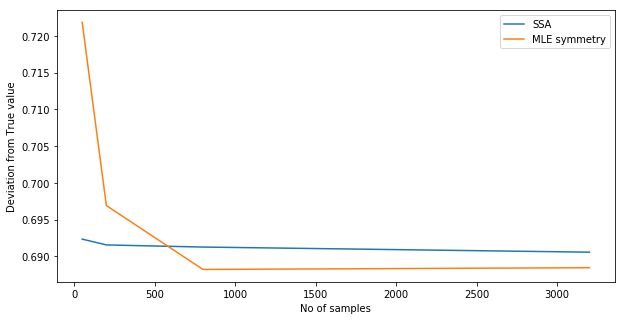

In [21]:
plt.figure(figsize=(10,5))
plt.plot(N,(np.mean(SSA_results,axis=0)),label='SSA')
plt.plot(N,np.mean(MLE_results,axis=0),label='MLE symmetry')
#plt.plot(N,np.mean(MLE_old_results,axis=0),label='MLE approximation')
#plt.plot(N,[0]*len(N),'--',label='0 Deviation from true value')
plt.xlabel('No of samples')
plt.ylabel('Deviation from True value')
plt.legend()

In [22]:
df = pandas.DataFrame(SSA_results[:,0],columns=['SSA'])
df['symmetric Beta'] = MLE_results[:,0]
df['full beta'] = MLE_old_results[:,0]
df.describe()

,SSA,symmetric Beta,full beta
count,10000.000000,10000.000000,10000.000000
mean,0.692342,0.721831,0.343761
std,0.089375,0.110035,0.349989
min,0.390065,0.356907,0.000000
25%,0.631966,0.646549,0.000000
50%,0.691762,0.719799,0.389420
75%,0.750938,0.795332,0.687379
max,1.010980,1.181681,1.131325
